In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#assignmnet 1 tna regression

#data
#loads the raw dataframes
probeA = pd.read_csv("C:\Users\pc\Python_Projects\MachineLearningWARWICK\data\probeData\probeA.csv",header=0)
probeB = pd.read_csv("C:\Users\pc\Python_Projects\MachineLearningWARWICK\data\probeData\probeB.csv",header=0)

# some values are "swapped" betweens columns, so we need to reorder:
def reorder(df):
    # From the initial data exploration it was clear that ther was some corruption in the form of a pemutation 
    #for each of the 4 proteins. This code reorders it.
    copydf=df.copy()
    for letter in ["c","m","n","p"]:
        old_c = copydf[[letter+"1",letter+"2",letter+"3"]]
        c = old_c.values
        c.sort(axis=1)
        c_df = pd.DataFrame(c,columns=old_c.columns)
        copydf[old_c.columns] = c_df
    return copydf

#scale data in standard way
def scale_data(dataFrame):
    df = dataFrame.copy()

    for var in df:
        mean = df[var].mean()
        std = df[var].std()
        assert(std != 0)
        df[var] = (df[var]-mean)/std
    
    return df

In [18]:
#cleaning up and preprocessing

from sklearn import preprocessing as pp
#reorder data
probeA = reorder(probeA)
probeB = reorder(probeB)

#stores everything apart tna and class column
probeA_data =probeA.drop('tna',1).drop('class',1)
probeA_data_std = scale_data(probeA_data)

probeB_data =probeB
probeB_data_std = scale_data(probeB_data)

tna_target = probeA['tna']
class_target = probeA['class']


In [19]:
#feature expansion
def polynomial_feature_ord(X,n):
    poly = pp.PolynomialFeatures(n)
    out = poly.fit_transform(X)
    feature_names = poly.get_feature_names(X.columns)
    
    X_new = pd.DataFrame(out,columns =feature_names)
    return X_new

data_ord_2 = polynomial_feature_ord(probeA_data_std,2)
data_ord_3 = polynomial_feature_ord(probeA_data_std,3)
data_ord_4 = polynomial_feature_ord(probeA_data_std,4)

data_tna = probeA_data_std.copy()
data_tna['tna'] = tna_target

data_ord_2_tna = polynomial_feature_ord(data_tna,2).drop('1',1)

data_ord_3_tna = polynomial_feature_ord(data_tna,3).drop('1',1)

data_ord_4_tna = polynomial_feature_ord(data_tna,4).drop('1',1)

In [20]:
# regression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation as cv
from sklearn.metrics import mean_squared_error

#here we arbitrary feature selected and we imporved generally!
#ridge ends up doing better!

features = ['c3' ,'c1^2', 'm1 n3' ,'m2^2', 'n1 p1', 'n3^2', 'p1^2']
data = data_ord_2[features]


models = [LassoCV(),RidgeCV(),LinearRegression()]
fitted_models = []

for model in models:
    print(model)
    m = model
    kf = cv.KFold(1000,50)
    sum_err = 0
    for train,test in kf:

        
        X_train = data.iloc[train].copy()
        y_train  = tna_target.iloc[train].copy()
        X_test = data.iloc[test].copy()
        y_test  = tna_target.iloc[test].copy()
        
        fitted = m.fit(X_train,y_train)
        predict = m.predict(X_test)
        sum_err += mean_squared_error(predict,y_test)
        print(mean_squared_error(predict,y_test))
    print('error for model: '+str(sum_err/50))
    print(model.alpha_)
    


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)
1.34593265907
1.51478939396
1.40785401555
0.864686058977
1.02516447559
0.734130692471
1.16452013068
1.68023066435
1.93813960025
1.26495910339
0.854167209224
1.12594120112
1.37702918413
0.819238594163
1.07178417726
1.97247855278
1.21649645637
1.10090296206
0.804556420167
1.21304641679
2.18167171119
0.688206793379
2.17049983408
1.08893280754
1.01061998284
1.66120422229
0.997378815215
1.09606738893
1.73506066397
0.92670685251
0.52977958024
1.54997037143
1.06766508693
0.872942218827
0.877124643788
0.858365421937
1.48617314229
1.03018085464
1.88258730267
1.33085211655
1.13985376091
1.01935747956
0.707902667755
1.136663048
1.25359609595
1.30834546035
0.691684838725
1.32622175777
1.23553911226
1.15281088939
error for model: 1.21020025781
0.0206196132271


AttributeError: 'LinearRegression' object has no attribute 'alpha_'

In [ ]:
#exploration to find important features in order 2 expansion
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
#found before: 0.0914285714286,0.0914285714286
#but with LassoCV: 0.0629693194436 , 0.0629694


for alpha in np.linspace( 0.0629693194436 , 0.0629694):
    print(alpha)
    print('#######################')
    m = Lasso(alpha)
    kf = cv.KFold(1000,50)
    sum_err = 0
    for train,test in kf:

        
        X_train = data.iloc[train].copy()
        y_train  = tna_target.iloc[train].copy()
        X_test = data.iloc[test].copy()
        y_test  = tna_target.iloc[test].copy()
        
        fitted = m.fit(X_train,y_train)
        feature_names = np.array(X_train.columns)
        model = SelectFromModel(m, prefit=True)
        selected_features = feature_names[model.get_support()]
        print selected_features
        predict = m.predict(X_test)
        sum_err += mean_squared_error(predict,y_test)
        print(mean_squared_error(predict,y_test))

        
        
    print('error for model: '+str(sum_err/50))
    print('###########################')
    
    
    #result: looks like 
    #['c3' 'c1^2' 'm1 n3' 'm2^2' 'n1 p1' 'n3^2' 'p1^2'] are important

In [ ]:
#we try to use the feature selected above to see if we have any improvements
features = ['c3' ,'c1^2', 'm1 n3' ,'m2^2', 'n1 p1', 'n3^2', 'p1^2']

data = data_ord_2[features]
print(data)
for alpha in np.linspace( 0.0629693194436 , 0.0629694):
    print(alpha)
    print('#######################')
    m = Lasso(alpha)
    kf = cv.KFold(1000,50)
    sum_err = 0
    for train,test in kf:

        
        X_train = data.iloc[train].copy()
        y_train  = tna_target.iloc[train].copy()
        X_test = data.iloc[test].copy()
        y_test  = tna_target.iloc[test].copy()
        
        fitted = m.fit(X_train,y_train)
        feature_names = np.array(X_train.columns)
        model = SelectFromModel(m, prefit=True)
        selected_features = feature_names[model.get_support()]
        #print selected_features
        predict = m.predict(X_test)
        sum_err += mean_squared_error(predict,y_test)
        print(mean_squared_error(predict,y_test))

        
        
    print('error for model: '+str(sum_err/50))
    print('###########################')
    
    
    #With the feature selected we actually got better values!
    #error with order 2 1.21852975368
    #changing order didn't seem to improve

In [ ]:
# we now do similar things to above but for ridge
from sklearn.linear_model import Ridge
features = ['c1', 'c2', 'c3', 'c1 c2', 'c1 c3', 'c1 n3' ,'c1 p1', 'c1 p2' ,'c3 n2', 'c3 n3','m1 n3' ,'n1 p1' ,'n2 p1' ,'n2 p2' ,'p1^2' ,'p2 p3']
#tried this aswell but works worse
features2 = ['c3' ,'c1^2', 'm1 n3' ,'m2^2', 'n1 p1', 'n3^2', 'p1^2']
data = data_ord_2[features]


for alpha in np.linspace(6.49747554165,50):
    print(alpha)
    print('#######################')
    m = Ridge(alpha)
    kf = cv.KFold(1000,100)
    sum_err = 0
    det_score = 0
    for train,test in kf:

        
        X_train = data.iloc[train].copy()
        y_train  = tna_target.iloc[train].copy()
        X_test = data.iloc[test].copy()
        y_test  = tna_target.iloc[test].copy()
        
        fitted = m.fit(X_train,y_train)
        feature_names = np.array(X_train.columns)
        model = SelectFromModel(m, prefit=True)
        selected_features = feature_names[model.get_support()]
        #print selected_features
        predict = m.predict(X_test)
        sum_err += mean_squared_error(predict,y_test)
        det_score += m.score(X_test,y_test)
        #print(det_score)
        print(mean_squared_error(predict,y_test))

        
        
    print('error for model: '+str(sum_err/100)+'  with alpha:'+str(alpha)+'and order 2')
    print('determination score'+str(det_score/float(100)))
    print('###########################')
    
    #0.0408163265306,0.0816326530612
    #0.0483132028321,0.0499791753436
    #result: looks like 
    

In [ ]:
## from sklearn.linear_model import RidgeCV
rid = RidgeCV()
rid.fit(data_ord_3,tna_target)
rid.alpha_


It seems Ridge regression does far worse than Lasso where we obtain some good mean squared error.
With this we get 1.21852975368 with poly order 2 and automatic cross val over the alpha and feature selection to ['c3' 'c1^2' 'm1 n3' 'm2^2' 'n1 p1' 'n3^2' 'p1^2']. 
We get similar results with manual search between 0.0483132028321,0.0499791753436 without having to do feature selection.
In both Rifge and Lasso it seemed like increasing the order didn't bring any improvement to the mean squared error.
With an arbitrary threshold it looke like lasso said these are some important features:
['c3' 'c1^2' 'm1 n3' 'm2^2' 'n1 p1' 'n3^2' 'p1^2']
Ridge bestC alpha cv seem to be 10 for all order.
Also ridge important features seem to be the following:

CHANGE! Actually Ridge is better: 1.20311622873  obtained with order 2 data feature selected with ['c1', 'c2', 'c3', 'c1 c2', 'c1 c3', 'c1 n3' ,'c1 p1', 'c1 p2' ,'c3 n2', 'c3 n3','m1 n3' ,'n1 p1' ,'n2 p1' ,'n2 p2' ,'p1^2' ,'p2 p3'].
Even with the regularisation 10 found by RidgeCV we get lower than lasso.
UPDATE! Using Ridge as before (order 2, fatures ['c1', 'c2', 'c3', 'c1 c2', 'c1 c3', 'c1 n3' ,'c1 p1', 'c1 p2' ,'c3 n2', 'c3 n3','m1 n3' ,'n1 p1' ,'n2 p1' ,'n2 p2' ,'p1^2' ,'p2 p3']) but with alpha between 6.49625156185,6.49750104123 we obtain 1.20292815273 !!
WEIRDLY ENOUGH, the Determination Score determination score0.765028763036 is maximised aroun 10.5 or something but then the error increases...

BUT: So far the best regression with both Score determination and means squared error haas been given by LassoCV which finds and alpha value of 0.0518035145118 with ORDER 3 and not even any feature selection!! The MSE and R2 score are:
1.10840298353
0.87571087707

In [ ]:
#uses f_classif to SelectKBest
#experiment to see if it matches with Lasso feature select above
from sklearn.feature_selection import SelectKBest, f_regression


# Perform feature selection
selector = SelectKBest(f_regression, k=7)
selector.fit(data_ord_2, tna_target)

# Get the raw p-values for each feature, and transform from p-values into scores
#scores = -np.log10(selector.pvalues_)
print zip(selector.get_support(),data_ord_3.columns)
# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(data_ord_3.columns)), scores)
plt.xticks(range(len(data_ord_3.columns)), data_ord_3.columns, rotation='vertical')
plt.show()

# with order 2, and f_regression
# (True, 'p1^2'), (True, 'p1 p2'), (True, 'p1 p3'), (True, 'p2^2'), (True, 'p2 p3'), (True, 'p3^2')
#not very good

In [22]:
#decision tree regression
from sklearn import tree
from sklearn.cross_validation import cross_val_score
features=['c1', 'c2', 'c3', 'c1 c2', 'c1 c3', 'c1 n3' ,'c1 p1', 'c1 p2' ,'c3 n2', 'c3 n3','m1 n3' ,'n1 p1' ,'n2 p1' ,'n2 p2' ,'p1^2' ,'p2 p3']

features2 = [u'c3', u'm1 n3', u'm3 n3', u'n1 n3', u'p1^2']
data = data_ord_2[features2]
depth = []
for i in range(1,60):
    clf = tree.DecisionTreeRegressor(max_depth=i)
    scores = cross_val_score(estimator=clf, X=data, y=tna_target, cv=10)
    print(str(i)+' '+str(scores.mean()))
    depth.append((i,scores.mean()))
    
#best_depth =7 for order 2
#0.658422546097

1 0.32133275097


NotFittedError: Estimator not fitted, call `fit` before `feature_importances_`.

Index([u'c3', u'c3 m3', u'm1 n3', u'm3 n3', u'p1^2'], dtype='object')
1.08730720125


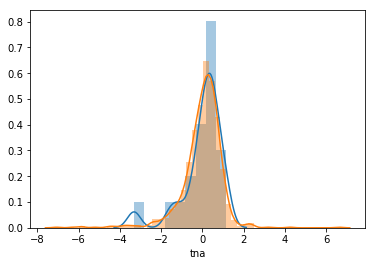

In [23]:
#decision tree regression: best features
from sklearn import tree

def cutoff_importances(importances,threshold,names):
    compare = importances > threshold
    return names[compare == True]

max_depth =7
clf = tree.DecisionTreeRegressor(max_depth=max_depth)
clf.fit(data_ord_2,tna_target)
#arbitrary threshold explore
print cutoff_importances(clf.feature_importances_,0.5e-2,data_ord_2.columns)

#mean square error of this model
print mean_squared_error(clf.predict(data_ord_2),tna_target)

#Index([u'c3', u'm1 n3', u'm3 n3', u'n1 n3', u'p1^2'], dtype='object')
#so similar values


sns.distplot((predict-predict.mean())/(predict.std()))
sns.distplot((tna_target-tna_target.mean())/(tna_target.std()))


In [ ]:
#We redo decision tree regressor this time with cross validation done mannually
features=['c1', 'c2', 'c3', 'c1 c2', 'c1 c3', 'c1 n3' ,'c1 p1', 'c1 p2' ,'c3 n2', 'c3 n3','m1 n3' ,'n1 p1' ,'n2 p1' ,'n2 p2' ,'p1^2' ,'p2 p3']
features2 = [u'c3', u'm1 n3', u'm3 n3', u'n1 n3', u'p1^2']
features3 = ['c3','p3','m1 n3','m2 n1','n3^2' ,'p1^2' ,'c1 c3 m1' ,'c1 m2 m3', 'c1 m2 n2','c1 m3 p3' ,'c2 m1 m3' ,'c2 n2 p2' ,'c3 m3 n2' ,'c3 n1 p2' ,'c3 p1^2','n2 p2 p3']
data = data_ord_2[features]


for max_depth in range(1,100):

    m = tree.DecisionTreeRegressor(max_depth=max_depth)
    kf = cv.KFold(1000,10)
    sum_err = 0
    for train,test in kf:

        
        X_train = data.iloc[train].copy()
        y_train  = tna_target.iloc[train].copy()
        X_test = data.iloc[test].copy()
        y_test  = tna_target.iloc[test].copy()
        
        fitted = m.fit(X_train,y_train)
        feature_names = np.array(X_train.columns)
        model = SelectFromModel(m, prefit=True)
        selected_features = feature_names[model.get_support()]
        print selected_features
        predict = m.predict(X_test)
        sum_err += m.score(X_test,y_test)
        #print(mean_squared_error(predict,y_test))

        
        
    print('error for model: '+str(sum_err/10)+'with depth: '+str(max_depth))
    print('###########################')
    



In [ ]:
#exploration to find important features in order 2 expansion
data = data_ord_2

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
for alpha in np.linspace(0.0489795918367,0.0514285714286):
    print(alpha)
    print('#######################')
    m = Lasso(alpha)
    kf = cv.KFold(1000,10)
    sum_err = 0
    for train,test in kf:

        
        X_train = data.iloc[train].copy()
        y_train  = tna_target.iloc[train].copy()
        X_test = data.iloc[test].copy()
        y_test  = tna_target.iloc[test].copy()
        
        fitted = m.fit(X_train,y_train)
        feature_names = np.array(X_train.columns)
        model = SelectFromModel(m, prefit=True)
        selected_features = feature_names[model.get_support()]
        #print selected_features
        predict = m.predict(X_test)
        sum_err += mean_squared_error(predict,y_test)
        print(mean_squared_error(predict,y_test))

        
        
    print('error for model: '+str(sum_err/10))
    print('###########################')
    
    

In [ ]:
data = data_ord_3

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
for alpha in np.linspace(0.051,0.052):
    print(alpha)
    print('#######################')
    m = Lasso(alpha)
    kf = cv.KFold(1000,10)
    sum_err = 0
    for train,test in kf:

        
        X_train = data.iloc[train].copy()
        y_train  = tna_target.iloc[train].copy()
        X_test = data.iloc[test].copy()
        y_test  = tna_target.iloc[test].copy()
        
        fitted = m.fit(X_train,y_train)
        feature_names = np.array(X_train.columns)
        model = SelectFromModel(m, prefit=True)
        selected_features = feature_names[model.get_support()]
        #print selected_features
        predict = m.predict(X_test)
        sum_err += mean_squared_error(predict,y_test)
        print(mean_squared_error(predict,y_test))

        
        
    print('error for model: '+str(sum_err/10))
    print('###########################')
    
    

In [ ]:
sns.distplot((tna_target-tna_target.mean())/(tna_target.std()))

In [ ]:
from scipy.stats import skew 

sns.distplot((tna_target-tna_target.mean())/(tna_target.std()))
#print skew(tna_target)
#interesting: the data is skewed on the left...what does it mean?

m = LassoCV()

m.fit(data_ord_3,tna_target)
print(m.alpha_)
predict = m.predict(data_ord_3)
#print skew(predict)
print(mean_squared_error(predict,tna_target))
print(m.score(data_ord_3,tna_target))
print(m.coef_)
print(m.get_support())
sns.distplot((predict-predict.mean())/(predict.std()))

#LassoCV finds a alpha =0.0518035145118
#for order 3 expan..this much better then order 2


In [ ]:
#Try the things from before with cross validation:
features =[u'c3', u'm1 n3', u'm3 n3', u'n1 n3', u'p1^2']
data = data_ord_2[features]
kf = cv.KFold(1000,10)

#for alpha in np.linspace(0.0043, 0.0046):
#print(alpha)
sum_score = 0
sum_err = 0
for train,test in kf:
    print('start fold')
    X_train = data.iloc[train].copy()
    y_train  = tna_target.iloc[train].copy()
    X_test = data.iloc[test].copy()
    y_test  = tna_target.iloc[test].copy()
    m = Lasso(alpha=0.0043)
    #m = LassoCV()
    fitted = m.fit(X_train,y_train)

    feature_names = np.array(X_train.columns)
    model = SelectFromModel(m, prefit=True)
    selected_features = feature_names[model.get_support()]
    #print selected_features
    predict = m.predict(X_test)
    sum_err += mean_squared_error(predict,y_test)
    sum_score += fitted.score(X_test,y_test)




print('score for model: '+str(sum_score/10))
print('error for model: '+str(sum_err/10))
print('###########################')
#alpha = 0.0043
#score for model: 0.851696864765
#error for model: 1.21039657058

We had forgot about cross validation but it still looks like we 10 fold we get 0.840584952765 det score using order 3 and no feature selection using lassoCV.
Order 4 becomes significantly worse.
ACTUALLY! Order 2 is better than order 3, no feature selection with LassoCV.0.849724840956
CHANGE! Maybe using LassoCV in each fold was over fitting? To be sure, we can pick just the alpha 0.0535918367347 that gives us
score for model: 0.85003332207
error for model: 1.22344836438

Even better with features =[u'c3', u'm1 n3', u'm3 n3', u'n1 n3', u'p1^2'] and alpha = 0.0043,score for model: 0.851696864765,error for model: 1.21039657058

In [ ]:
data = data_ord_3

from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectFromModel
for alpha in np.linspace(1.0,20):
    print(alpha)
    print('#######################')
    m = Ridge(alpha)
    kf = cv.KFold(1000,10)
    sum_err = 0
    for train,test in kf:

        
        X_train = data.iloc[train].copy()
        y_train  = tna_target.iloc[train].copy()
        X_test = data.iloc[test].copy()
        y_test  = tna_target.iloc[test].copy()
        
        fitted = m.fit(X_train,y_train)
        feature_names = np.array(X_train.columns)
        model = SelectFromModel(m, prefit=True)
        selected_features = feature_names[model.get_support()]
        #print selected_features
        predict = m.predict(X_test)
        sum_err += mean_squared_error(predict,y_test)
        print(mean_squared_error(predict,y_test))

        
        
    print('error for model: '+str(sum_err/10))
    print('###########################')
    

In [ ]:
from scipy.stats import skew 

sns.distplot((tna_target-tna_target.mean())/(tna_target.std()))
print skew(tna_target)
#interesting: the data is skewed on the left...what does it mean?

m = RidgeCV()

m.fit(data_ord_3,tna_target)
print(m.alpha_)
predict = m.predict(data_ord_3)
print skew(predict)
print(mean_squared_error(predict,tna_target))
sns.distplot((predict-predict.mean())/(predict.std()))

#RidgeCV finds a alpha =10
#for order 3 expan..this much better then order 2

In [ ]:
sns.distplot(probeA_data_std['p2'])

In [ ]:
probeA_data_std_class = probeA_data_std
probeA_data_std_class['class'] = class_target
probeA_data_std_class.head()
sns.pairplot(probeA_data_std_class,hue='class',kind='reg')

In [ ]:
sns.pairplot(probeB_data_std)

From the above we can observe that the data from probA and probB seem to follow the same general pattern so we can assume that probeB will be the test set of the train set probA.

In [ ]:
 #classification
    
#first we do it without trying to use tna
#decision tree classifier

#decision tree regression
from sklearn import tree
from sklearn.cross_validation import cross_val_score

depth = []
for i in range(1,100):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(estimator=clf, X=data_ord_4, y=class_target, cv=10)
    print(scores.mean())
    depth.append((i,scores.mean()))
#best_depth = 3 for data ord 2
#0.710044
#best_depth = 3 for data ord 3 aswell
#0.70303460346
#data ord 4 seems inferior

In [ ]:
#decsion tree importances
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(data_ord_2,class_target)
importances = clf.feature_importances_
#arbitrary thre
print cutoff_importances(importances,0.017,data_ord_2.columns)

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=data_ord_2.columns,  
                         class_names=['0','1'],  
                         filled=True, rounded=True,  
                         special_characters=True)
#print the tree
print(dot_data)

Use website:
https://dreampuf.github.io/GraphvizOnline/
To render the DOT file above and get a graphical representation of the decision tree 

In [ ]:
img = pd.read_csv("C:\Users\pc\Python_Projects\MachineLearningWARWICK\data\probeData\probeB.csv",header=0)

In [ ]:
#now we do it using tna (the actual values!)
#decision tree classifier

#decision tree regression
from sklearn import tree
from sklearn.cross_validation import cross_val_score

depth = []
for i in range(1,100):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(estimator=clf, X=data_ord_2_tna, y=class_target, cv=10)
    print(scores.mean())
    depth.append((i,scores.mean()))
'''   
0.78600550055
0.776065906591
0.83001740174
0.82803720372
0.83003680368
0.82203620362
0.822066506651
0.81901640164
0.805055405541
0.79904570457
0.80703580358
0.808075807581
0.80000590059
0.8010360036
0.805085508551
0.801065906591
0.80704610461
0.808065706571
0.801055605561
0.821076207621
0.793056205621
0.81002630263
0.810056205621
0.8050360036
0.81101640164
0.804065706571
0.81001620162
0.8089959996
0.81603620362
0.82000590059
0.806065306531
0.80100570057
0.81697639764
0.807065906591
0.80702610261
0.81800650065
0.80800590059
0.80198649865
0.80704590459
0.80004590459
0.80600570057
0.81201620162
0.806055805581
0.802055805581
0.80001580158
0.80403580358
0.809056005601
0.81604610461
0.80104610461
0.8120160016
0.80602570257
0.81703620362
0.805065706571
0.80804570457
0.80202590259
0.80802570257
0.81102630263
0.81501620162
0.81096629663
0.81202630263
0.79801560156
0.81000610061
0.801075807581
0.79604570457
0.80501580158
0.799056005601
0.804066106611
0.81501620162
0.80500630063
0.804055805581
0.798056005601
0.8050360036
0.80902630263
0.7960160016
0.79602590259
0.798075607561
0.80104550455
0.81202610261
0.802065306531
0.80704610461
0.8070160016
0.81903640364
0.80702570257
0.803055805581
0.80403620362
0.8000160016
0.81204610461
0.80402610261
0.79603580358
0.802065706571
0.804055805581
0.80604590459
0.80702590259
0.80304550455
0.80503560356
0.81102590259
0.801055205521
0.81400630063
0.79703580358
''' 


In [ ]:
#drop ones

data_ord_2_bias = data_ord_2.copy()
data_ord_2_bias = data_ord_2.drop('1',1)
data_ord_3_bias = data_ord_3.copy()
data_ord_3_bias = data_ord_3.drop('1',1)
data_ord_4_bias = data_ord_4.copy()
data_ord_4_bias = data_ord_4.drop('1',1)

To do: 
1) use best regression method so far, get predictions for TNA and then try classifying 'class' remebering to feature expand with the predicted tna
2) use k-nn with weighted malanhobis distance to classify . Without tna and with as before

In [ ]:
# kNN for classification using Mahlanobis without using tna
# use
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

data = data_ord_2_tna


kf = cv.KFold(1000,10)
sum_err= 0
for train,test in kf:


    X_train = data.iloc[train].copy()
    y_train  = class_target.iloc[train].copy()
    X_test = data.iloc[test].copy()
    y_test  = class_target.iloc[test].copy()
    
    knn = KNeighborsClassifier(n_neighbors=50,metric='mahalanobis',metric_params={'V': np.cov(data.transpose())},weights='distance')

    predict = knn.predict(X_test)
    sum_err += accuracy_score(predict,y_test)
    print(accuracy_score(predict,y_test))
print('average accuracy: '+str(sum_err/10))

In [ ]:
data_ord_2.shape

Solve the problem above: how to use poly feature with malanobi knn